# PREPARACIÓN DEL CÓDIGO DE PRODUCCIÓN

## EMPAQUETAR TODO EL PROCESO EN FUNCIONES

### Calidad de datos

In [1]:
def calidad_datos(x):
    
    #Modificar tipos
    temp = x.astype({'month': 'O', 'wday': 'O'})             
    
    #Imputar nulos
    temp.loc[x['event_name_1'].isna(),'event_name_1'] = 'Sin_evento'
    
    def imputar_moda(registros):
        #Calcula la moda del precio en ese producto
        moda = registros.sell_price.mode()[0]
        #Imputa los nulos
        registros.loc[registros.sell_price.isna(),'sell_price'] = moda
        #Devuelve todos los registros del producto
        return(registros)

    temp = temp.groupby('item_id', group_keys=False).apply(imputar_moda)
      
    return(temp)

### Creación de variables

In [2]:
def crear_variables(x):
    
    #DEMANDA INTERMITENTE
    
    def rotura_stock(ventas, n = 5):
        cero_ventas = pd.Series(np.where(ventas == 0,1,0))
        num_ceros = cero_ventas.rolling(n).sum()
        rotura_stock = np.where(num_ceros == n,1,0)
        return(rotura_stock)
    
    x = x.sort_values(by = ['store_id','item_id','date'])
    x['rotura_stock_3'] = x.groupby(['store_id','item_id']).ventas.transform(lambda x: rotura_stock(x, 3)).values
    x['rotura_stock_7'] = x.groupby(['store_id','item_id']).ventas.transform(lambda x: rotura_stock(x,7)).values
    x['rotura_stock_15'] = x.groupby(['store_id','item_id']).ventas.transform(lambda x: rotura_stock(x,15)).values
    
    
    #LAGS
    
    def crear_lags(x, variable, num_lags = 7):
        lags = pd.DataFrame()
        for cada in range(1,num_lags+1):
            lags[variable + '_lag_'+ str(cada)] = x[variable].shift(cada)
        return(lags)
    
    lags_sell_price_df = (x.groupby(['store_id', 'item_id'])
                        .apply(lambda x: crear_lags(x = x, variable = 'sell_price', num_lags= 7))
                        .reset_index()
                        .set_index('date'))
    
    lags_rotura_stock_3_df = (x.groupby(['store_id','item_id'])
                            .apply(lambda x: crear_lags(x = x, variable = 'rotura_stock_3', num_lags= 1))
                            .reset_index()
                            .set_index('date'))
    
    lags_rotura_stock_7_df = (x.groupby(['store_id','item_id'])
                            .apply(lambda x: crear_lags(x = x, variable = 'rotura_stock_7', num_lags= 1))
                            .reset_index()
                            .set_index('date'))
    
    lags_rotura_stock_15_df = (x.groupby(['store_id','item_id'])
                            .apply(lambda x: crear_lags(x = x, variable = 'rotura_stock_15', num_lags= 1))
                            .reset_index()
                            .set_index('date'))
    
    lags_ventas_df = (x.groupby(['store_id','item_id'])
                    .apply(lambda x: crear_lags(x = x, variable = 'ventas', num_lags= 15))
                    .reset_index()
                    .set_index('date'))
    
    
    #VENTANAS MÓVILES
    
    def min_movil(x, variable, num_periodos = 7):
        minm = pd.DataFrame()
        for cada in range(2,num_periodos+1):
            minm[variable + '_minm_' + str(cada)] = x[variable].shift(1).rolling(cada).min()
        return(minm)
    
    def media_movil(x, variable, num_periodos = 7):
        mm = pd.DataFrame()
        for cada in range(2,num_periodos+1):
            mm[variable + '_mm_' + str(cada)] = x[variable].shift(1).rolling(cada).mean()
        return(mm)
    
    def max_movil(x, variable, num_periodos = 7):
        maxm = pd.DataFrame()
        for cada in range(2,num_periodos+1):
            maxm[variable + '_maxm_' + str(cada)] = x[variable].shift(1).rolling(cada).max()
        return(maxm)
    
    min_movil_df = (x.groupby(['store_id','item_id'])
                  .apply(lambda x: min_movil(x = x, variable = 'ventas', num_periodos= 15))
                  .reset_index()
                  .set_index('date'))
    
    media_movil_df = (x.groupby(['store_id','item_id'])
                    .apply(lambda x: media_movil(x = x, variable = 'ventas', num_periodos= 15))
                    .reset_index()
                    .set_index('date'))
    
    max_movil_df = (x.groupby(['store_id','item_id'])
                    .apply(lambda x: max_movil(x = x, variable = 'ventas', num_periodos= 15))
                    .reset_index()
                    .set_index('date'))
    
    
    #UNIR DATAFRAMES GENERADOS

    x_unido = pd.concat([x,
                      lags_sell_price_df,
                      lags_rotura_stock_3_df,
                      lags_rotura_stock_7_df,
                      lags_rotura_stock_15_df,
                      lags_ventas_df,
                      min_movil_df,
                      media_movil_df,
                      max_movil_df], axis = 1)

    # Eliminar columnas duplicadas
    x_unido = x_unido.loc[:,~x_unido.columns.duplicated()]
    
    x_unido.dropna(inplace=True)
    
    x_unido.drop(columns = ['sell_price','rotura_stock_3','rotura_stock_7','rotura_stock_15'],
                  inplace=True)
    
    #Crear una sola variable para el producto
    x_unido.insert(loc=0,column='producto',value=x_unido.store_id + '_'+ x_unido.item_id)
    x_unido = x_unido.drop(columns = ['store_id','item_id'])
    
    return(x_unido)

### Transformación de variables

In [10]:
def transformar_variables(x,y=None,modo = 'entrenamiento'):
    
    '''
    He modificado esta función para que sirva tanto para entrenamiento como para ejecución:

    * Incluyendo el parámetro modo, que por defecto es entrenamiento
    * Haciendo que el parámetro y sea opcional, ya que en ejecución no se usa

    Cuando se usa en modo entrenamiento aplica el método fit_transform y guarda los objetos.

    Mientras que cuando se usa en modo ejecución carga los objetos y aplica solo el método transform.
    '''    
    
    x.reset_index(inplace = True)

    #GESTION DE LOS ENCODERS
    nombre_ohe = 'ohe_retail.pickle'
    nombre_te = 'te_retail.pickle'
    ruta_ohe = ruta_proyecto + '/04_Modelos/' + nombre_ohe
    ruta_te = ruta_proyecto + '/04_Modelos/' + nombre_te
    
    #ONE HOT ENCODING
    var_ohe = ['event_name_1']
    if modo == 'entrenamiento':
        #Si está en entrenamiento aplica fit_transform y guarda el encoder
        ohe = OneHotEncoder(sparse_output = False, handle_unknown='ignore')
        ohe_x = ohe.fit_transform(x[var_ohe])
        ohe_x = pd.DataFrame(ohe_x, columns = ohe.get_feature_names_out())
        with open(ruta_ohe, mode='wb') as file:
           pickle.dump(ohe, file)
    else:
        #Si está en ejecución recupera el guardado y solo aplica transform
        with open(ruta_ohe, mode='rb') as file:
            ohe = pickle.load(file)
        ohe_x = ohe.transform(x[var_ohe])
        ohe_x = pd.DataFrame(ohe_x, columns = ohe.get_feature_names_out())

    #TARGET ENCODING    
    var_te = ['month','wday','weekday']
    if modo == 'entrenamiento':
        #ASEGURAR QUE Y TIENE LOS MISMOS REGISTROS QUE X
        y.reset_index(inplace = True, drop = True)
        y = y.loc[y.index.isin(x.index)]
        #Si está en entrenamiento aplica fit_transform y guarda el encoder
        te = TargetEncoder(min_samples_leaf=100, return_df = False)
        te_x = te.fit_transform(x[var_te], y = y)
        nombres_te = [variable + '_te' for variable in var_te]
        te_x = pd.DataFrame(te_x, columns = nombres_te)
        with open(ruta_te, mode='wb') as file:
           pickle.dump(te, file)
    else:
        #Si está en ejecución recupera el guardado y solo aplica transform
        with open(ruta_te, mode='rb') as file:
            te = pickle.load(file)
        te_x = te.transform(x[var_te])
        nombres_te = [variable + '_te' for variable in var_te]
        te_x = pd.DataFrame(te_x, columns = nombres_te)
    
      
    #INTEGRAR, LIMPIAR Y DEVOLVER EL DATAFRAME
    #Eliminar las originales ya transformadas
    x = x.drop(columns=['event_name_1','month','wday','weekday'])
    #Incorporar los otros dataframes
    x = pd.concat([x,ohe_x,te_x], axis=1).set_index('date')

    #Salida
    return(x)

### Preselección de variables

In [4]:
def preseleccionar_variables(x,y):
    
    '''
    Sólo hay que usarla en entrenamiento.
    '''
    #ELIMINAR LA COLUMNA PRODUCTO Y EL INDEX
    x.reset_index(drop = True,inplace = True)
    x.drop(columns='producto',inplace = True)
    
    #ASEGURAR QUE Y TIENE LOS MISMOS REGISTROS QUE X
    y = y.loc[y.index.isin(x.index)]
    

    mutual_selector = mutual_info_regression(x,y)
    posicion_variable_limite = 73
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ['variable','importancia_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importancia_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    entran_mi = ranking_mi.iloc[0:posicion_variable_limite].variable
    x_mi = x[entran_mi].copy()

    return(x_mi)

### Modelización

#### Entrenamiento

In [5]:
def modelizar(x_producto, y):
    
    '''
    Esta función es la que hace la modelización individual.

    Recibe los datos de las x y la y de un producto.

    Encuentra los parámetros óptimos para ese producto.

    Devuelve el mejor modelo.
    '''
      
    #Excluye el producto como variable de modelización
    var_modelizar = x_producto.columns.to_list()[2:]
    
    #Define la validación cruzada
    time_cv = TimeSeriesSplit(5, test_size = 8)
    
    #Define la parrilla de algoritmos
    pipe = Pipeline([('algoritmo',HistGradientBoostingRegressor())])
    
    grid = [ 
         {'algoritmo': [HistGradientBoostingRegressor()]
#          'algoritmo__learning_rate': [0.01,0.025,0.05,0.1],
#          'algoritmo__max_iter': [50,100,200],
#          'algoritmo__max_depth': [5,10,20,50],
#          'algoritmo__scoring': ['neg_mean_absolute_error'],
#          'algoritmo__l2_regularization': [0,0.25,0.5,0.75,1]
         }
                       
    ]
           
    #Crea los modelos
    random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 1, 
                                   cv = time_cv, 
                                   scoring = 'neg_mean_absolute_error', 
                                   verbose = 0,
                                   n_jobs = -1)
    
    modelo = random_search.fit(x_producto[var_modelizar],y)
    
    #Reentrena el mejor sobre todos los datos
    modelo_final = modelo.best_estimator_.fit(x_producto[var_modelizar],y)
    
    #Devuelve como salida el modelo final
    return(modelo_final)

In [6]:
def lanzar_entrenamiento(df):
    
    '''
    Esta función va recorriendo todos los productos y llamando a modelizar() para crear una lista total con todos los modelos de todos los productos.

    Recibe el dataframe de las x ya limpio y segmentado por producto, y también la target.

    No devuelve nada, si no que guarda en disco el objeto ya entrenado con todos los modelos.
    '''
    
    lista_productos = list(df.producto.unique())
    
    lista_modelos =[] 
    
    for cada in lista_productos:
        
        #Renombra por claridad
        producto = cada
        target = 'ventas'

        x = df.loc[df.producto == producto].copy().drop(columns=target).copy()
        y = df.loc[df.producto == producto,'ventas'].copy()

        x = transformar_variables(x,y)
        x = preseleccionar_variables(x,y)
        
        #Llama a la funcion de modelizar
        modelo = modelizar(x,y)
        
        #Añade el modelo final a la lista
        lista_modelos.append((producto,modelo))
        
    #Guarda la lista de modelos entrenados
    nombre_modelos = 'lista_modelos_retail.pickle'
    ruta_modelos = ruta_proyecto + '/04_Modelos/' + nombre_modelos
    with open(ruta_modelos, mode='wb') as file:
       pickle.dump(lista_modelos, file)

#### Ejecución

In [7]:
#Lanzar la predicción
def lanzar_ejecucion(df):
    
    '''
    Esta función hace el forecast para cada producto, pero solo de un día.

    Recibe el nuevo dataset a predecir.
    
    Que tiene que tener la estructura del fichero DatosParaProduccion.csv de la carpeta Validación.

    Va recorriendo cada producto, cargando su modelo correspondiente, seleccionando sus datos, y haciendo las predicciones.

    Devuelve la predicción para todos los productos pero SOLO PARA EL DÍA QUE TOCA.
    '''
    
    #CARGA LOS MODELOS
    nombre_modelos = 'lista_modelos_retail.pickle'
    ruta_modelos = ruta_proyecto + '/04_Modelos/' + nombre_modelos
    with open(ruta_modelos, mode='rb') as file:
       lista_modelos = pickle.load(file)
    
    predicciones_df = pd.DataFrame(columns=['date','producto','ventas','prediccion'])
    
    for cada in range(0,len(lista_modelos)):

        producto = lista_modelos[cada][0]
        modelo = lista_modelos[cada][1]
        variables = modelo[0].feature_names_in_
        target = 'ventas'
        
        x = df.loc[df.producto == producto].copy().drop(columns=target).copy()
        y = df.loc[df.producto == producto,'ventas'].copy()
        
        date = df.reset_index().copy()
        date = date.loc[date.producto == producto,'date'].values

        #Transformacion de variables
        x = transformar_variables(x, modo = 'ejecucion')
        
        #Seleccion de variables
        x = x[variables]
        
        #Cálculo de predicciones
        predicciones = pd.DataFrame(data={'date': date,
                                          'producto': producto,
                                          'ventas': y,
                                          'prediccion': modelo.predict(x)})

        predicciones['prediccion'] = predicciones.prediccion.astype('int')

        predicciones_df = pd.concat([predicciones_df,predicciones])
    
    predicciones_df = predicciones_df.loc[predicciones_df.index == predicciones_df.index.min()]
    return(predicciones_df)

In [8]:
def forecast_recursivo(x):
    
    '''
    Esta función es la que aplica el forecast recursivo para predecir 8 días.
    
    Recibe el nuevo dataset a predecir.

    Que tiene que tener la estructura del fichero DatosParaProduccion.csv de la carpeta Validación. 
    
    Ya que para aplicar la recursividad:

    * Va a predecir el primer día para el cual tenga toda la información (es decir 15 días desde el día más antiguo)
    * Al finalizar graba la predicción de ventas en el registro a predecir y elimina los registros del día más antiguo del dataframe
    * Por tanto en la siguiente iteración va a predecir el siguiente día.

    Por ejemplo:

    Si el día más antiguo del dataset es el 09/12/2015 entonces el primer día que puede predecir
    
    (y del cual ya no tenemos dato) es el 24/12/2015.

    Cuando predice el dato del 24 para cada producto lo sobrescribe como sus ventas
    
    y elimina todos los registros del día 09.

    Entonces el día más antiguo pasa a ser el día 10 y por tanto el día a predecir es el 25.

    Y así hasta que finaliza 8 ciclos para predecir la semana que queremos.
    '''
    
    for cada in range(0,8):
        paso1_df = calidad_datos(x)
        paso2_df = crear_variables(paso1_df)
        
        #Calcula la predicción
        f = lanzar_ejecucion(paso2_df)
        f['store_id'] = f.producto.str[:4]
        f['item_id'] = f.producto.str[5:]

        #Actualiza el dato de ventas con la predicción
        x.loc[(x.index.isin(f.date)) & (x.store_id.isin(f.store_id)) & (x.item_id.isin(f.item_id)),'ventas'] = f.prediccion
                                                              
        #Elimina el día más antiguo de x
        x = x.loc[x.index != x.index.min()]
        
    return(x)

## PROCESO

### REENTRENAMIENTO

In [11]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import TimeSeriesSplit

from sklearn.pipeline import Pipeline

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

#Cargar los datos
ruta_proyecto = 'C:/Users/pelop/OneDrive/Desktop/Curso Data Science Pedro/2 CURSO DATA SCIENCE/03_MACHINE_LEARNING/07_CASOS/02_RETAIL/'
nombre_fichero_datos = 'trabajo.csv'
ruta_completa = ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_fichero_datos
df = pd.read_csv(ruta_completa,sep=',',parse_dates=['date'],index_col='date')

#Seleccionar solo las que se han usado
variables_finales = ['store_id',
                     'item_id',
                     'event_name_1',                     
                     'month',
                     'sell_price',                      
                     'wday',
                     'weekday',
                     'ventas']

df = df[variables_finales]

paso1_df = calidad_datos(df)
paso2_df = crear_variables(paso1_df)

lanzar_entrenamiento(paso2_df)

### EVALUACIÓN

In [13]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

#Cargar los datos
ruta_proyecto = 'C:/Users/pelop/OneDrive/Desktop/Curso Data Science Pedro/2 CURSO DATA SCIENCE/03_MACHINE_LEARNING/07_CASOS/02_RETAIL/'
nombre_fichero_datos = 'validacion.csv'
ruta_completa = ruta_proyecto + '/02_Datos/02_Validacion/' + nombre_fichero_datos
df = pd.read_csv(ruta_completa,sep=',',parse_dates=['date'],index_col='date')

#Seleccionar solo las que se han usado
variables_finales = ['store_id',
                     'item_id',
                     'event_name_1',                     
                     'month',
                     'sell_price',                      
                     'wday',
                     'weekday',
                     'ventas']


df = df[variables_finales]

paso1_df = calidad_datos(df)
paso2_df = crear_variables(paso1_df)

forecast_1dia = lanzar_ejecucion(paso2_df)

print('MAE = ', mean_absolute_error(forecast_1dia.ventas,forecast_1dia.prediccion))

forecast_1dia

MAE =  5.3


,date,producto,ventas,prediccion
2015-12-16,2015-12-16,CA_3_FOODS_3_090,0,-9
2015-12-16,2015-12-16,CA_3_FOODS_3_120,52,51
2015-12-16,2015-12-16,CA_3_FOODS_3_202,20,14
2015-12-16,2015-12-16,CA_3_FOODS_3_252,36,35
2015-12-16,2015-12-16,CA_3_FOODS_3_288,35,23
2015-12-16,2015-12-16,CA_3_FOODS_3_329,64,43
2015-12-16,2015-12-16,CA_3_FOODS_3_555,30,28
2015-12-16,2015-12-16,CA_3_FOODS_3_586,76,63
2015-12-16,2015-12-16,CA_3_FOODS_3_587,29,33
2015-12-16,2015-12-16,CA_3_FOODS_3_714,19,16


### EJECUCIÓN

In [50]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

#Cargar los datos
ruta_proyecto = 'C:/Users/pelop/OneDrive/Desktop/Curso Data Science Pedro/2 CURSO DATA SCIENCE/03_MACHINE_LEARNING/07_CASOS/02_RETAIL/'
nombre_fichero_datos = 'DatosParaProduccion.csv'
ruta_completa = ruta_proyecto + '/02_Datos/02_Validacion/' + nombre_fichero_datos
df = pd.read_csv(ruta_completa,sep=';',parse_dates=['date'],index_col='date')

#Seleccionar solo las que se han usado
variables_finales = ['store_id',
                     'item_id',
                     'event_name_1',                     
                     'month',
                     'sell_price',                      
                     'wday',
                     'weekday',
                     'ventas']

df = df[variables_finales]

#Lanzar la predicción
forecast = forecast_recursivo(df)

forecast.sort_values(by = ['store_id','item_id'])

,store_id,item_id,event_name_1,month,sell_price,wday,weekday,ventas
date,,,,,,,,
17/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,6,Thursday,0
18/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,7,Friday,1
19/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,1,Saturday,0
20/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,2,Sunday,6
21/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,3,Monday,4
...,...,...,...,...,...,...,...,...
27/12/2015,CA_4,FOODS_3_714,NaN,12,1.58,2,Sunday,14
28/12/2015,CA_4,FOODS_3_714,NaN,12,1.58,3,Monday,8
29/12/2015,CA_4,FOODS_3_714,NaN,12,1.58,4,Tuesday,7


#### Evaluación de los resultados tras ejecución

In [89]:
forecast = forecast.sort_values(by = ['store_id','item_id'])
forecast.rename(columns = {'ventas':'prediccion'}, inplace = True)

nombre_fichero_datos = 'validacion.csv'
ruta_completa = ruta_proyecto + '/02_Datos/02_Validacion/' + nombre_fichero_datos
df_validacion = pd.read_csv(ruta_completa,sep=',',parse_dates=['date'],index_col='date')
df_validacion.sort_values(by = ['store_id','item_id'])
df_validacion = df_validacion.loc[df_validacion.index >= '17/12/2015',:].sort_values(by = ['store_id','item_id'])

df_evaluation = pd.concat([forecast.reset_index(),df_validacion.reset_index().ventas], axis = 'columns').set_index('date')

In [90]:
df_evaluation

,store_id,item_id,event_name_1,month,sell_price,wday,weekday,prediccion,ventas
date,,,,,,,,,
17/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,6,Thursday,0,0
18/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,7,Friday,1,1
19/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,1,Saturday,0,0
20/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,2,Sunday,6,6
21/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,3,Monday,4,4
...,...,...,...,...,...,...,...,...,...
27/12/2015,CA_4,FOODS_3_714,NaN,12,1.58,2,Sunday,14,5
28/12/2015,CA_4,FOODS_3_714,NaN,12,1.58,3,Monday,8,7
29/12/2015,CA_4,FOODS_3_714,NaN,12,1.58,4,Tuesday,7,8


In [91]:
df_evaluation.insert(loc=0,column='producto',value=df_evaluation.store_id + '_'+ df_evaluation.item_id)
df_evaluation = df_evaluation.drop(columns = ['store_id','item_id'])
df_evaluation = df_evaluation[['producto','ventas','prediccion']]
df_evaluation

,producto,ventas,prediccion
date,,,
17/12/2015,CA_3_FOODS_3_090,0,0
18/12/2015,CA_3_FOODS_3_090,1,1
19/12/2015,CA_3_FOODS_3_090,0,0
20/12/2015,CA_3_FOODS_3_090,6,6
21/12/2015,CA_3_FOODS_3_090,4,4
...,...,...,...
27/12/2015,CA_4_FOODS_3_714,5,14
28/12/2015,CA_4_FOODS_3_714,7,8
29/12/2015,CA_4_FOODS_3_714,8,7


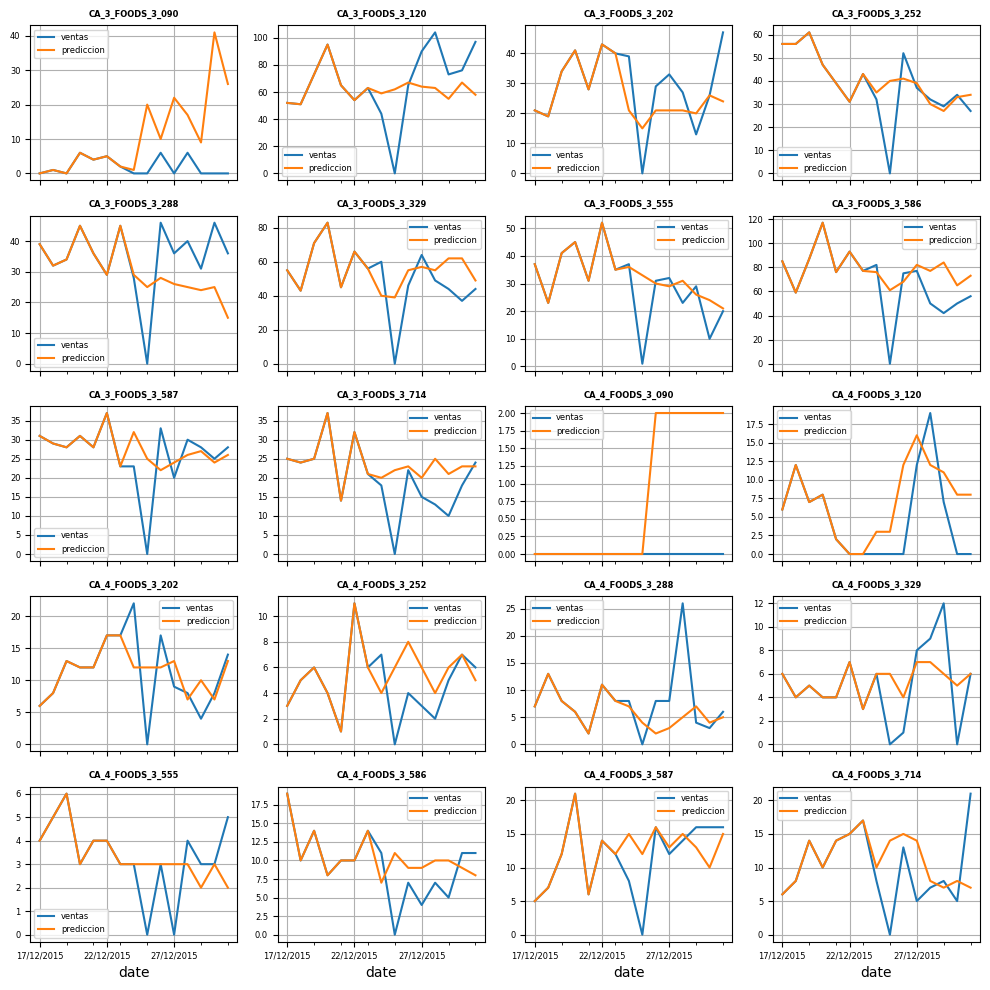

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

lista_productos = list(df_evaluation.producto.unique())
f, ax = plt.subplots(5,4, figsize = (10,10), sharex = True)
ax = ax.flat

for cada in range(0,len(lista_productos)):
    df_evaluation[df_evaluation.producto == lista_productos[cada]].plot(ax = ax[cada])
    ax[cada].set_title(lista_productos[cada], fontsize = 6, fontweight = "bold")
    ax[cada].tick_params(labelsize = 6)
    ax[cada].legend(fontsize = 6)
    ax[cada].grid()

plt.tight_layout()
plt.savefig('exhibit_7.png')

In [94]:
print('MAE = ', mean_absolute_error(df_evaluation.ventas,df_evaluation.prediccion))

MAE =  4.726666666666667
